## Вариант 4

## Задание 1

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags, identity
from scipy.sparse.linalg import spsolve

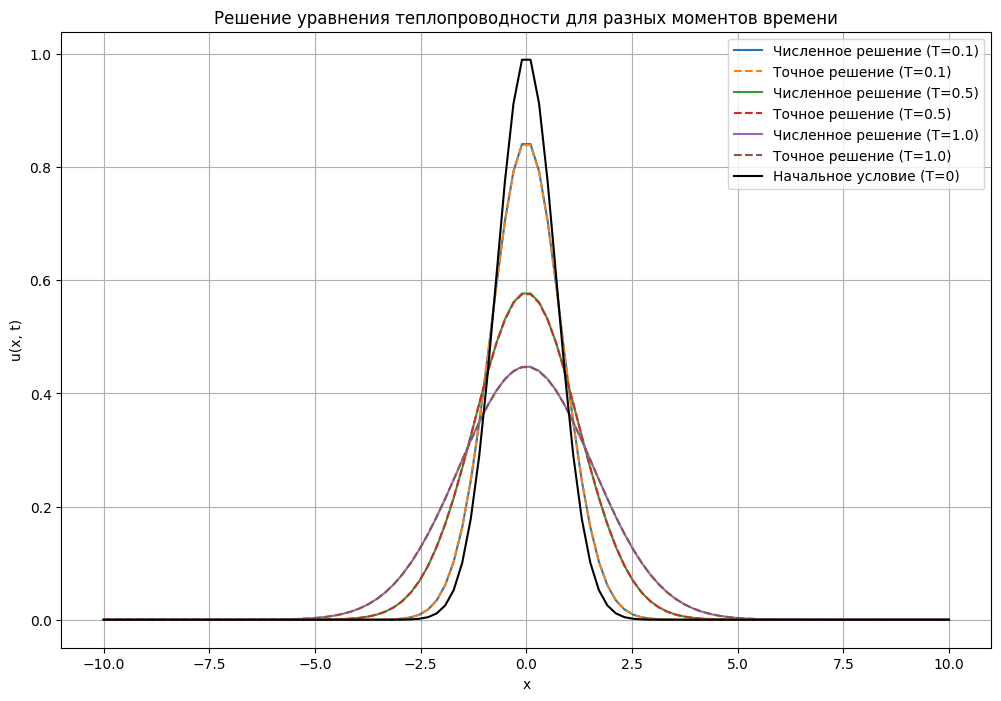

In [15]:
# Параметры задачи
L = 10.0      # Половина длины области (x ∈ [-L, L])
T_list = [0.1, 0.5, 1.0]  # Разные моменты времени для визуализации
N = 100      # Число узлов по пространству
M = 100      # Число узлов по времени
x = np.linspace(-L, L, N)
h = x[1] - x[0]

# Начальное условие u0 = exp(-x^2)
u0 = np.exp(-x**2)

# Точное решение
def exact_solution(x, t):
    return np.exp(-x**2 / (4 * t + 1)) / np.sqrt(4 * t + 1)

# Параметры DIRK метода
gamma = 1 - 1/np.sqrt(2)
a11 = gamma
a22 = gamma
a21 = 1 - gamma
b1 = 1 - gamma
b2 = gamma

# Матрица для пространственной дискретизации (второй порядок, разреженная CSR)
A = diags([1, -2, 1], [-1, 0, 1], shape=(N-2, N-2), format='csr') / h**2
I = identity(N-2, format='csr')

# Функция для вычисления правой части (F(u) = A @ u)
def F(u):
    return (np.roll(u, 1) - 2 * u + np.roll(u, -1)) / h**2

# Решение методом DIRK для разных T
plt.figure(figsize=(12, 8))

for T in T_list:
    t = np.linspace(0, T, M)
    tau = t[1] - t[0]
    
    u = np.zeros((M, N))
    u[0, :] = u0

    for n in range(M - 1):
        un = u[n, :]
        
        # Первая стадия (k1)
        rhs = F(un)[1:-1]
        k1 = np.zeros(N)
        k1[1:-1] = spsolve(I - tau * a11 * A, rhs)
        
        # Вторая стадия (k2)
        rhs = F(un + tau * a21 * k1)[1:-1]
        k2 = np.zeros(N)
        k2[1:-1] = spsolve(I - tau * a22 * A, rhs)
        
        # Обновление решения
        u[n+1, :] = un + tau * (b1 * k1 + b2 * k2)
        
        # Однородные краевые условия
        u[n+1, 0] = exact_solution(x[0], t[n+1])
        u[n+1, -1] = exact_solution(x[-1], t[n+1])
    
    # Визуализация для текущего T
    plt.plot(x, u[-1, :], label=f'Численное решение (T={T})')
    plt.plot(x, exact_solution(x, T), '--', label=f'Точное решение (T={T})')

plt.plot(x, u0, 'k-', label='Начальное условие (T=0)')
plt.xlabel('x')
plt.ylabel('u(x, t)')
plt.legend()
plt.title('Решение уравнения теплопроводности для разных моментов времени')
plt.grid()
plt.show()



Порядок сходимости:
N=50->100: 2.5693
N=100->200: 2.5315
N=200->400: 3.4316


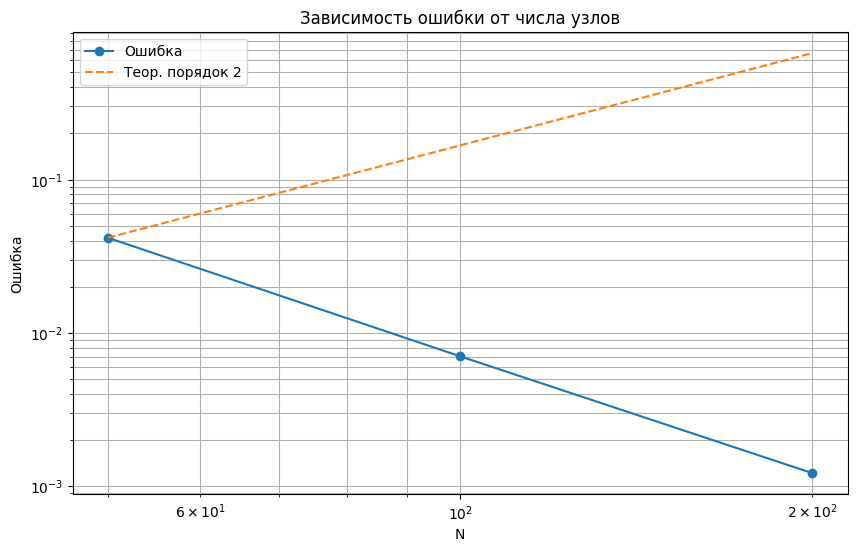

In [16]:
# Проверка порядка сходимости (для T=0.1)
T = 0.1
N_list = [50, 100, 200, 400]
errors = []

for N in N_list:
    M = N  # tau = h
    x = np.linspace(-L, L, N)
    h = x[1] - x[0]
    t = np.linspace(0, T, M)
    tau = t[1] - t[0]
    
    A = diags([1, -2, 1], [-1, 0, 1], shape=(N-2, N-2), format='csr') / h**2
    I = identity(N-2, format='csr')
    
    u = np.zeros((M, N))
    u[0, :] = np.exp(-x**2)
    
    for n in range(M - 1):
        un = u[n, :]
        rhs = (un[:-2] - 2*un[1:-1] + un[2:]) / h**2
        k1 = np.zeros(N)
        k1[1:-1] = spsolve(I - tau*a11*A, rhs)
        
        u_star = un + tau*a21*k1
        rhs = (u_star[:-2] - 2*u_star[1:-1] + u_star[2:]) / h**2
        k2 = np.zeros(N)
        k2[1:-1] = spsolve(I - tau*a22*A, rhs)
        
        u[n+1] = un + tau*(b1*k1 + b2*k2)
        u[n+1, [0, -1]] = exact_solution(x[[0, -1]], t[n+1])
    
    # Интерполяция на общую сетку для сравнения
    if N != N_list[-1]:
        x_fine = np.linspace(-L, L, N_list[-1])
        u_interp = np.interp(x_fine, x, u[-1])
        u_exact = exact_solution(x_fine, T)
        errors.append(np.linalg.norm(u_interp - u_exact, 2) * np.sqrt(h))
    else:
        u_exact = exact_solution(x, T)
        errors.append(np.linalg.norm(u[-1] - u_exact, 2) * np.sqrt(h))

# Расчёт порядка сходимости
print("\nПорядок сходимости:")
for i in range(len(errors)-1):
    p = np.log2(errors[i]/errors[i+1])
    print(f"N={N_list[i]}->{N_list[i+1]}: {p:.4f}")

# График ошибок
plt.figure(figsize=(10, 6))
plt.loglog(N_list[:-1], errors[:-1], 'o-', label='Ошибка')
plt.loglog(N_list[:-1], [errors[0]/(N_list[0]/n)**2 for n in N_list[:-1]], '--', label='Теор. порядок 2')
plt.xlabel('N')
plt.ylabel('Ошибка')
plt.legend()
plt.grid(True, which='both')
plt.title('Зависимость ошибки от числа узлов')
plt.show()

## Задача 2

u(0,t)=0, v(0,t)=t

Для гиперболических систем требуется ровно одно граничное условие на каждой характеристике, входящей в область.

В данном случае при 
c>0:


На левой границе 
x=0 входят обе характеристики, следовательно, требуется два граничных условия на левой границе, что и задано

На правой границе x=L
условия не заданы - это корректно для неограниченной области.

Вывод: постановка задачи корректна.

Используем явную схему "крест" с центральными разностями

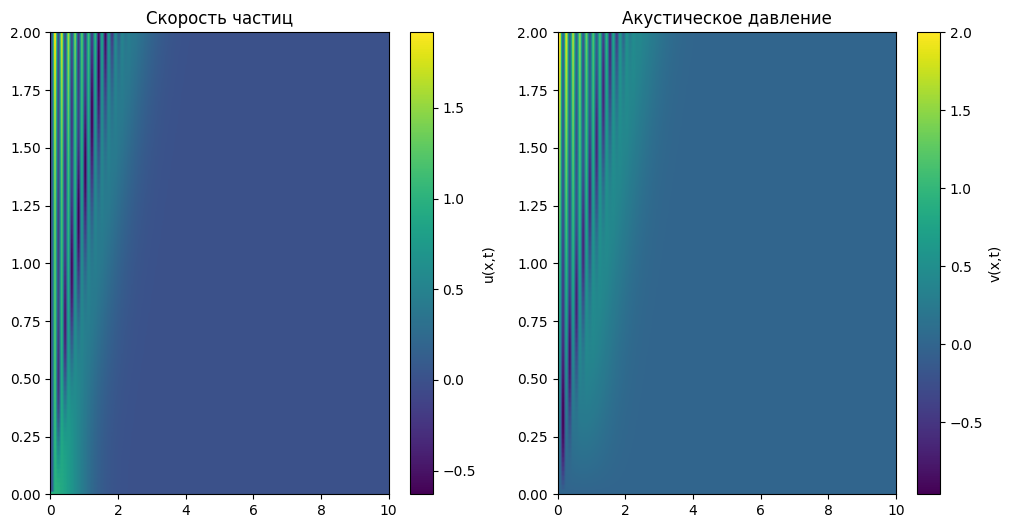

In [17]:
# Параметры
c = 1.0
L = 10.0
T = 2.0
N = 100  # Число узлов по пространству
M = 200  # Число узлов по времени
h = L/N
tau = T/M

# Начальные условия
def f(x): return np.exp(-x**2)
def g(x): return np.zeros_like(x)

# Сетки
x = np.linspace(0, L, N+1)
t = np.linspace(0, T, M+1)
u = np.zeros((M+1, N+1))
v = np.zeros((M+1, N+1))

# Задаем начальные условия
u[0,:] = f(x)
v[0,:] = g(x)

# Первый шаг (используем схему Лакса)
for j in range(1,N):
    u[1,j] = 0.5*(u[0,j+1] + u[0,j-1]) - c*tau/(2*h)*(v[0,j+1] - v[0,j-1])
    v[1,j] = 0.5*(v[0,j+1] + v[0,j-1]) - c*tau/(2*h)*(u[0,j+1] - u[0,j-1])

# Основной цикл
for n in range(1,M):
    # Граничные условия
    u[n+1,0] = 0.0
    v[n+1,0] = t[n+1]
    
    # Внутренние точки
    for j in range(1,N):
        u[n+1,j] = u[n-1,j] - c*tau/h*(v[n,j+1] - v[n,j-1])
        v[n+1,j] = v[n-1,j] - c*tau/h*(u[n,j+1] - u[n,j-1])
    
    # Правая граница (прозрачное условие)
    u[n+1,N] = u[n+1,N-1]
    v[n+1,N] = v[n+1,N-1]

# Визуализация
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(u, extent=[0,L,0,T], aspect='auto', origin='lower')
plt.colorbar(label='u(x,t)')
plt.title('Скорость частиц')

plt.subplot(122)
plt.imshow(v, extent=[0,L,0,T], aspect='auto', origin='lower')
plt.colorbar(label='v(x,t)')
plt.title('Акустическое давление')
plt.show()